In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pyart
%matplotlib inline

### Data ingest

In [2]:
def plot_list_of_fields(radar, sweep=0, fields=['reflectivity'], vmins=[0],
                        vmaxs=[65], units=['dBZ'], cmaps=['RdYlBu_r'],
                        return_flag=False, xlim=[-150, 150], ylim=[-150, 150],
                        mask_tuple=[None], titles=[None], columns=2):
    """
    Use Py-ART to make a multi-panel PPI plot of one or more fields.
    Final figure will be 1-3 panels wide, and however many panels are
    needed high.
    
    Arguments/Keywords
    ------------------
    radar = Py-ART radar object
    sweep = Sweep number to plot
    fields = List of names of fields to plot
    return_flag = Set to True to return Py-ART display object
    xlim, ylim = x and y limits for the plot (km from radar)
    columns = Maximum number of possible columns; limited to 1, 2, or 3
    
    Other keyword lists can be shorter than fields. If so, then the last
    item in the list is used for all remaining plots.
    
    vmins = List of minimum values to show
    vmaxs = List of maximum values to show
    units = List of strings for colorbar labels
    cmaps = List of colormaps
    mask_tuple = List of mask_tuple for each plot. Can be None.
    titles = List of titles for each plot. If None, will use Py-ART default.
    """
    alphabet = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)',
                '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', '(n)',
                '(o)', '(p)', '(q)', '(r)', '(s)', '(t)', '(u)',
                '(v)', '(w)', '(x)', '(y)', '(z)']
    num_fields = len(fields)
    if columns not in [1, 2, 3]:
        print('Uses 1, 2, or 3 columns only, exiting ...')
        return
    nrows = (num_fields + 1) // columns
    ncols = (num_fields + 1) % columns + 1
    if columns == 1:
        width = 7.0
    elif columns == 2:
        width = 14.0
    else:
        width = 20.0
    fig = plt.figure(figsize=(width, float(nrows)*5.5))
    display = pyart.graph.RadarDisplay(radar)
    # Handle shorter lists than fields without crashing
    for kw in [vmins, vmaxs, units, cmaps, titles, mask_tuple]:
        if num_fields > len(kw):
            for i in np.arange(num_fields-len(kw)):
                kw.append(kw[len(kw)-1])
    # Plot each field sequentially, adjusting location of subplot as needed
    for index, field in enumerate(fields):
        ax = fig.add_subplot(nrows, columns, index+1)
        display.plot_ppi(field, sweep=sweep, vmin=vmins[index],
                         vmax=vmaxs[index], mask_outside=True,
                         colorbar_label=units[index], cmap=cmaps[index],
                         mask_tuple=mask_tuple[index], title=titles[index])
        display.set_limits(xlim=xlim, ylim=ylim)
        plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]),
                 ylim[0]+0.90*(ylim[1]-ylim[0]), alphabet[index],
                 fontsize='x-large', weight='bold')
    plt.tight_layout()
    if return_flag:
        return display

In [3]:
BAD = -32768
REGION = 'VE_region'
PHASE = 'VE_phase'
DD4 = 'VE_4dd'

### First File

In [4]:
radar = pyart.io.read('./cfrad.20111110_070015.000_to_20111110_070750.000_toga_v0_SUR.nc')

In [5]:
corr_vel = pyart.correct.dealias_region_based(radar, keep_original=True, vel_field='VR', 
                                              interval_splits=3, skip_along_rays=100,
                                              skip_between_rays=100)
radar.add_field(REGION, corr_vel, replace_existing=True)

In [6]:
corr_vel = pyart.correct.dealias_unwrap_phase(radar, keep_original=False, vel_field='VR', 
                                              unwrap_unit='volume')
radar.add_field(PHASE, corr_vel, replace_existing=True)

/home/jhelmus/dev/pyart/pyart/graph/radardisplay.py:146: UserWarning: RadarDisplay does not correct for moving platforms
  warnings.warn('RadarDisplay does not correct for moving platforms')


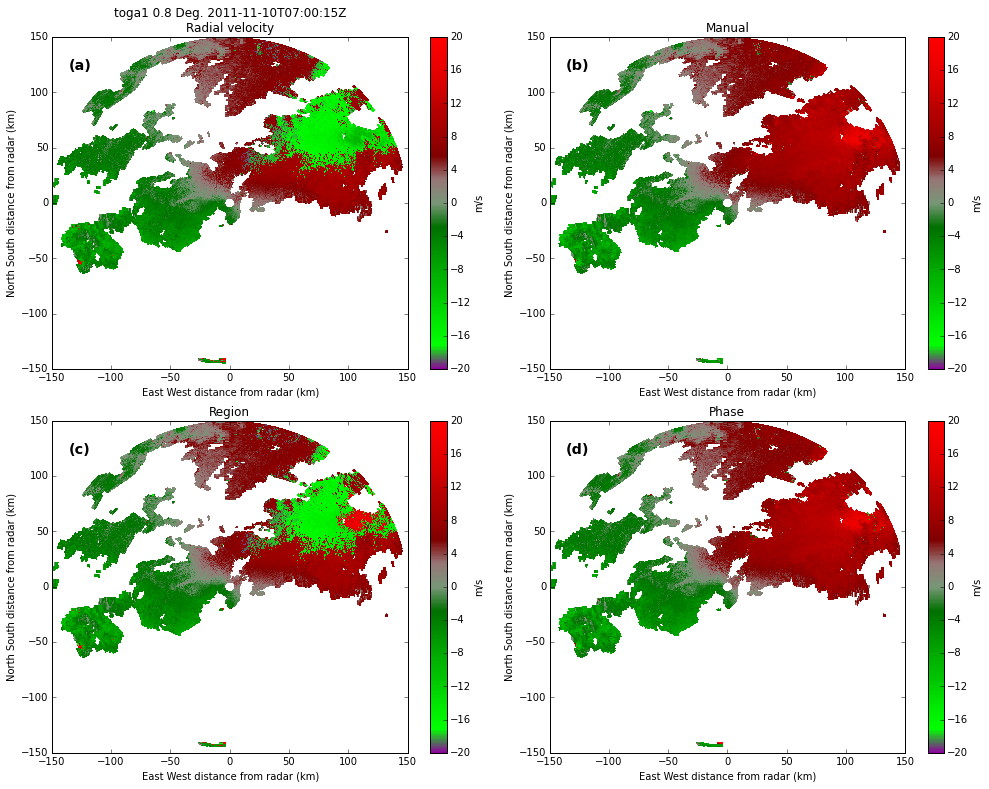

In [7]:
plot_list_of_fields(radar, sweep=0, fields=['VR', 'VE', REGION, PHASE], vmins=[-20],
                    vmaxs=[20], cmaps=['pyart_NWSVel'], units=['m/s'],
                    titles=[None, 'Manual', 'Region', 'Phase'])

###  Different file

In [8]:
radar = pyart.io.read('./cfrad.20111110_073017.000_to_20111110_073733.000_toga_v0_SUR.nc')

In [9]:
corr_vel = pyart.correct.dealias_region_based(radar, keep_original=True, vel_field='VR', 
                                              centered=True)
radar.add_field(REGION, corr_vel, replace_existing=True)

In [10]:
corr_vel = pyart.correct.dealias_unwrap_phase(radar, keep_original=False, vel_field='VR', 
                                              unwrap_unit='volume')
radar.add_field(PHASE, corr_vel, replace_existing=True)

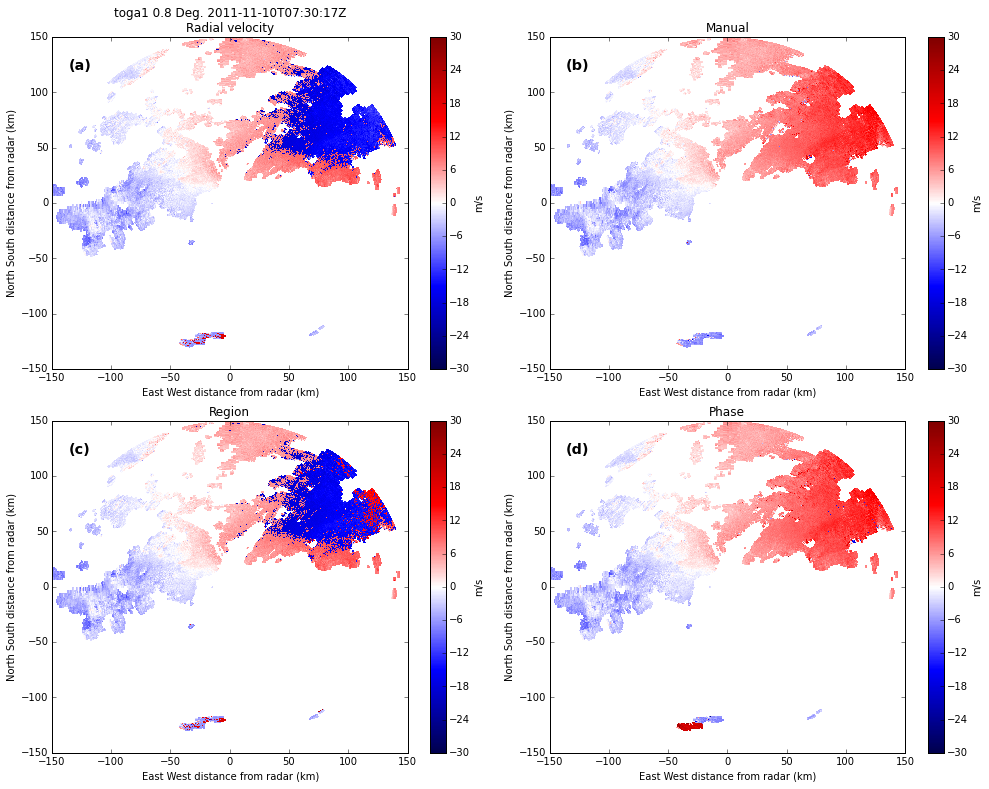

In [11]:
plot_list_of_fields(radar, sweep=0, fields=['VR', 'VE', REGION, PHASE], vmins=[-30],
                    vmaxs=[30], cmaps=['seismic'], units=['m/s'],
                    titles=[None, 'Manual', 'Region', 'Phase'])

---
Why are we getting such bad dealiasing from the region based algorith?  Let's explore the data from 2011-11-10 in more detail.

In [12]:
radar = pyart.io.read('./cfrad.20111110_070015.000_to_20111110_070750.000_toga_v0_SUR.nc')

In [13]:
print(radar.instrument_parameters['nyquist_velocity'])
nyquist = radar.instrument_parameters['nyquist_velocity']['data'][0]

{u'units': u'meters per second', u'long_name': u'unambiguous_doppler_velocity', 'data': array([ 13.35000038,  13.35000038,  13.35000038, ...,  13.35000038,
        13.35000038,  13.35000038], dtype=float32), u'meta_group': u'instrument_parameters', u'_fillValue': -9999.0}


In [14]:
print(radar.fields['VR']['data'].min(), radar.fields['VR']['data'].max())

-19.73 19.59


The Nyquist velocity is 13.35 meters per second but the raw velocity data contains gates with velocities above 19 meter per second.  This data has been at least partially unfolded (dual PRF?).  This causes issues because by default the region based unfolding algorithm only finds regions using intervals inside the Nyquist interval.  Therefore all bins with velocities outside this range are not unfolded.  We can visualize this using a **RadarDisplay**.

In [15]:
display = pyart.graph.RadarDisplay(radar)

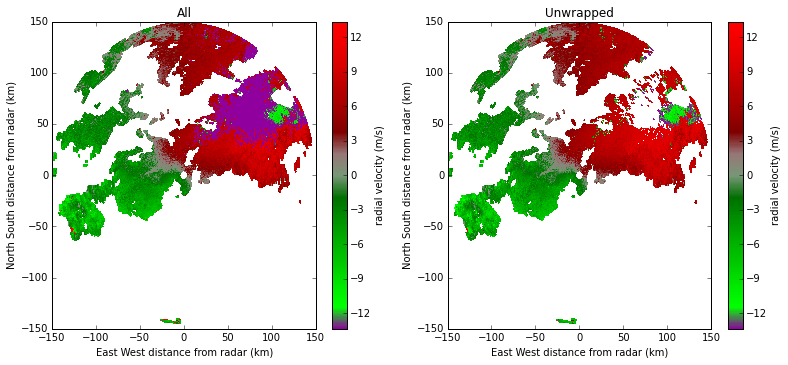

In [16]:
fig = plt.figure(figsize=(13, 5.5))
ax = fig.add_subplot(1, 2, 1)
display.plot_ppi('VR', vmin=-nyquist, vmax=nyquist, mask_outside=False, cmap='pyart_NWSVel', title='All')
ax = fig.add_subplot(1, 2, 2)
display.plot_ppi('VR', vmin=-nyquist, vmax=nyquist, mask_outside=True, cmap='pyart_NWSVel', title='Unwrapped')

In the above plot, region which are present on the left panel but missing in the right panel are all those which have velocities outside the Nyquist interval and therefore are not examined by the region based dealiasing method.  If we want these gates to be processed we need to adjust the interval limits which are used by the algorithm to find the similar regoins.

The default limits are defined by the *interval_splits* parameter which has a default value of 3.

In [17]:
interval_splits = 3
interval_limits = np.linspace(-nyquist, nyquist, interval_splits+1, endpoint=True)
print(interval_limits)

[-13.35000038  -4.45000013   4.45000013  13.35000038]


Expanding these limits to include velocities outside the nyquist interval:

In [18]:
interval_limits = np.linspace(-5/3.*nyquist, 5/3*nyquist, 5+1, endpoint=True)
print(interval_limits)

[-22.25000064 -13.35000038  -4.45000013   4.45000013  13.35000038
  22.25000064]


Using these new limits to unfold the volume

In [19]:
interval_limits = np.linspace(-5/3.*nyquist, 5/3*nyquist, 5+1, endpoint=True)
corr_vel = pyart.correct.dealias_region_based(radar, keep_original=True, vel_field='VR', 
                                              interval_limits=interval_limits, skip_along_rays=100,
                                              skip_between_rays=100)
radar.add_field(REGION, corr_vel, replace_existing=True)

In [20]:
corr_vel = pyart.correct.dealias_unwrap_phase(radar, keep_original=False, vel_field='VR', 
                                              unwrap_unit='volume')
radar.add_field(PHASE, corr_vel, replace_existing=True)

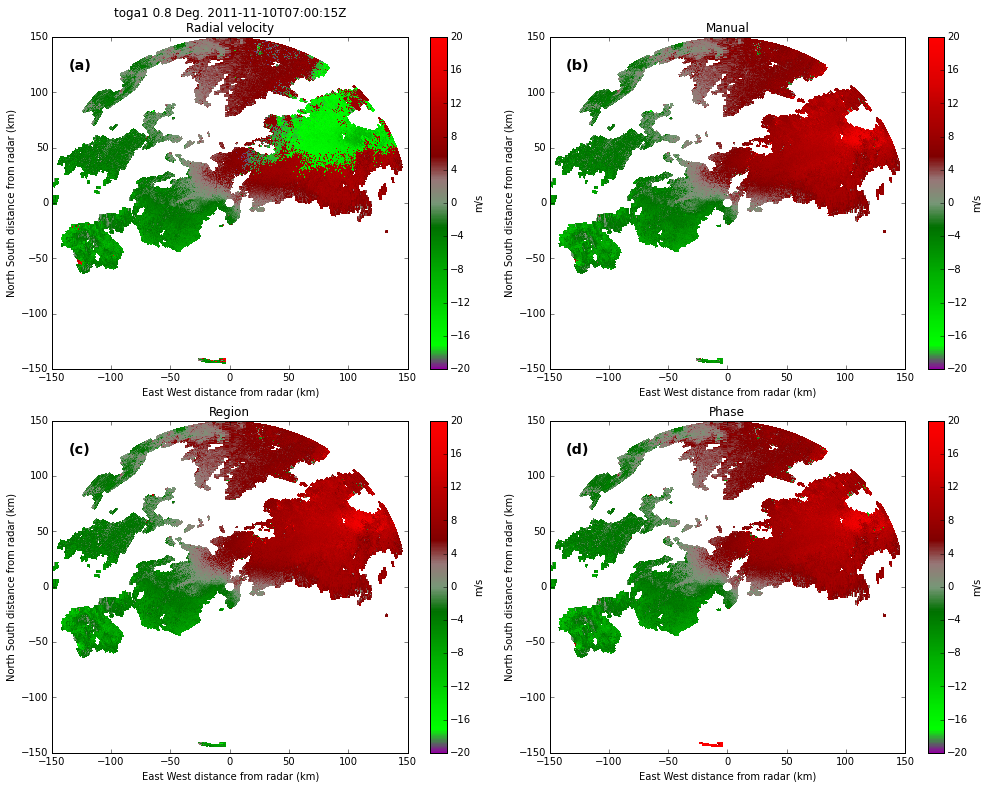

In [21]:
plot_list_of_fields(radar, sweep=0, fields=['VR', 'VE', REGION, PHASE], vmins=[-20],
                    vmaxs=[20], cmaps=['pyart_NWSVel'], units=['m/s'],
                    titles=[None, 'Manual', 'Region', 'Phase'])

---
Doing the same for the second file.

In [22]:
radar = pyart.io.read('./cfrad.20111110_073017.000_to_20111110_073733.000_toga_v0_SUR.nc')

In [23]:
print(radar.fields['VR']['data'].min(), radar.fields['VR']['data'].max())
print(radar.instrument_parameters['nyquist_velocity'])
nyquist = radar.instrument_parameters['nyquist_velocity']['data'][0]

-19.64 19.55
{u'units': u'meters per second', u'long_name': u'unambiguous_doppler_velocity', 'data': array([ 13.35000038,  13.35000038,  13.35000038, ...,  13.35000038,
        13.35000038,  13.35000038], dtype=float32), u'meta_group': u'instrument_parameters', u'_fillValue': -9999.0}


In [24]:
interval_limits = np.linspace(-5/3.*nyquist, 5/3*nyquist, 5+1, endpoint=True)
print(interval_limits)
corr_vel = pyart.correct.dealias_region_based(
    radar, keep_original=True, vel_field='VR', centered=True, interval_limits=interval_limits)
radar.add_field(REGION, corr_vel, replace_existing=True)

[-22.25000064 -13.35000038  -4.45000013   4.45000013  13.35000038
  22.25000064]


In [25]:
corr_vel = pyart.correct.dealias_unwrap_phase(radar, keep_original=False, vel_field='VR', 
                                              unwrap_unit='volume')
radar.add_field(PHASE, corr_vel, replace_existing=True)

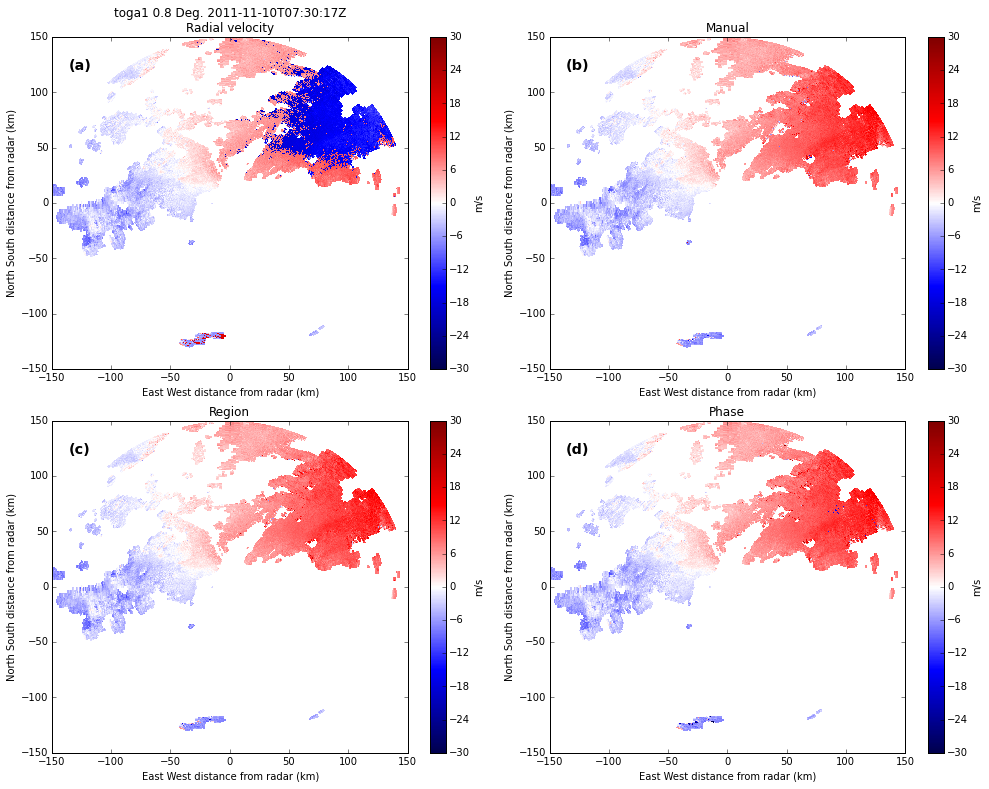

In [26]:
plot_list_of_fields(radar, sweep=0, fields=['VR', 'VE', REGION, PHASE], vmins=[-30],
                    vmaxs=[30], cmaps=['seismic'], units=['m/s'],
                    titles=[None, 'Manual', 'Region', 'Phase'])